In [147]:
import pandas as pd
import time
import boto3
from io import StringIO, BytesIO
import matplotlib.pyplot as plt
from fastavro import writer, parse_schema, reader
import pyarrow.parquet as pq
import pyarrow as pa
import datetime as dt

# Serializacion

Vamos analizar diferentes formatos de datos. Para esto los vamos a escribir y leer de un almacenamiento distribuido usando [minio](https://min.io/) un FOSS object store compatible con S3.

Estos formatos se pueden usar tanto para persistir los datos en el master dataset de una arquitectura lambda como para transferir informacion en su speed layer.

# Crear el bucket y traer los datos de prueba

Corriendo run_minio.sh se va a levantar un contenedor de docker con minio. Va a bindear el puerto 9000 a la api, y en el puerto 9090 podemos acceder a la ui web. Los datos se van a persistir en un volumen (./minio_data).

In [2]:
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html
s3 = boto3.client('s3',
                  endpoint_url='http://localhost:9000',
                  aws_access_key_id='catedra',
                  aws_secret_access_key='catedrapass')

In [3]:
fvehicular_bucket = 'flujovehicular'
if fvehicular_bucket not in [b["Name"] for b in s3.list_buckets()['Buckets']]:
    s3.create_bucket(Bucket=fvehicular_bucket)

In [4]:
DATASET_URL = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/flujo-vehicular-anillo-digital/dataset_flujo_vehicular.csv"
df = pd.read_csv(DATASET_URL)
df["HORA"] = pd.to_datetime(df["HORA"], format="%d%b%Y:%H:%M:%S")
df.head()

,CODIGO_LOCACION,HORA,CANTIDAD,SENTIDO,LATITUD,LONGITUD
0,48Q3CJ00+,2020-03-31 15:00:00,729,Interna,-34.588796,-58.381520
1,48Q3CJ00+,2020-03-31 15:00:00,447,Egreso,-34.588796,-58.381520
2,48Q39G00+,2020-03-31 15:00:00,175,Interna,-34.633299,-58.468594
3,48Q39G00+,2020-03-31 15:00:00,1186,Egreso,-34.633299,-58.468594
4,48Q3CH00+,2020-03-31 15:00:00,35,Egreso,-34.579632,-58.427733


# CSV

 - archivo de texto
 - orientado a filas
 - no tiene un esquema definido
 - no soporta cambios en el esquema 
 - los datos estan crudos
 - solo soporta tipos de datos primitivos
 - no contempla bloques para su organizacion
 - tenes que leer todo el archivo para hacer consultas
 - puede agregar filas a archivos existentes eficientemente
 - permite la inspeccion directa de los datos
 - sirve para trabajar con conjuntos de datos que entran en memoria

In [5]:
start_time = time.time()
with StringIO() as csv_buffer:
    df.to_csv(csv_buffer, index=False)
    s3.put_object(Body=csv_buffer.getvalue(), Bucket=fvehicular_bucket, Key='flujo.csv')
csv_write_time = time.time()-start_time
csv_write_time

1.729318380355835

In [6]:
start_time = time.time()
csv_object = s3.get_object(Bucket=fvehicular_bucket, Key='flujo.csv',)
df = pd.read_csv(csv_object["Body"], parse_dates=['HORA'])
csv_read_time = time.time() -start_time
csv_read_time

0.32969188690185547

In [7]:
csv_size = csv_object["ContentLength"]
csv_size

12109112

In [8]:
csv_object_body = s3.get_object(Bucket=fvehicular_bucket, Key='flujo.csv',)["Body"]
print(next(csv_object_body).decode())

CODIGO_LOCACION,HORA,CANTIDAD,SENTIDO,LATITUD,LONGITUD
48Q3CJ00+,2020-03-31 15:00:00,729,Interna,-34.588796,-58.38152
48Q3CJ00+,2020-03-31 15:00:00,447,Egreso,-34.588796,-58.38152
48Q39G00+,2020-03-31 15:00:00,175,Interna,-34.633299,-58.468594
48Q39G00+,2020-03-31 15:00:00,1186,Egreso,-34.633299,-58.468594
48Q3CH00+,2020-03-31 15:00:00,35,Egreso,-34.579632000000004,-58.427733
48Q3CH00+,2020-03-31 15:00:00,523,Interna,-34.579632000000004,-58.427733
48Q39J00+,2020-03-31 15:00:00,1670,Interna,-34.60855,-58.372951
48Q39G00+,2020-03-31 15:00:00,1235,Ingreso,-34.633299,-58.468594
48Q39G00+,2020-03-31 14:00:00,1535,Egreso,-34.633299,-58.468594
48Q3FG00+,2020-03-31 14:00:00,124,Interna,-34.53698,-58.470968000000006
48Q3CJ00+,2020-03-31 14:00:00,577,Egreso,-34.588796,-58.38152
48Q3CJ00+,2020-03-31 14:00:00,741,Interna,-34.588796,-58.38152
48Q3CJ00+,2020-03-31 14:00:00,543,Ingreso,-34.588796,-58.38152
48Q3CH00+,2020-03-31 14:00:00,600,Interna,-34.579632000000004,-58.427733
48Q3CH00+,2020-03-31 1

In [231]:
start_time = time.time()
csv_object = s3.get_object(Bucket=fvehicular_bucket, Key='flujo.csv',)
df = pd.read_csv(csv_object["Body"], parse_dates=['HORA'])
result_df = df.query("CANTIDAD > 13000 & SENTIDO=='Egreso'")
csv_query_time = time.time() -start_time
csv_query_time

0.32634925842285156

In [120]:
result_df

,CODIGO_LOCACION,HORA,CANTIDAD,SENTIDO,LATITUD,LONGITUD
5317,48Q39G00+,2020-03-10 17:00:00,13041,Egreso,-34.633299,-58.468594
6538,48Q39G00+,2020-03-06 17:00:00,13041,Egreso,-34.633299,-58.468594


In [232]:
start_time = time.time()
csv_object = s3.get_object(Bucket=fvehicular_bucket, Key='flujo.csv',)
df = pd.read_csv(csv_object["Body"], parse_dates=['HORA'])
result_seq_df = df.query("HORA > '2020-03-10 00:00' & HORA < '2020-03-12 00:00'")
csv_query_seq_time = time.time() -start_time
csv_query_seq_time

0.3542060852050781

In [208]:
len(result_seq_df)

495

# AVRO

 - archivo binario
 - orientado a filas
 - permite definir esquemas
 - soporta evolucion del esquema
 - ofrece opciones de compresion
 - permite definir tipos de datos
 - organiza los registros en bloques
 - permite predicate pushdown
 - puede agregar filas a archivos existentes eficientemente
 - se usa en streams como kafka o sistemas de almacenamiento distirbuido como hadoop o s3
 - *su uso no esta pensado para trabajar sobre un solo archivo
 - se enfoca en el intercambio de datos entre sistemas

In [217]:
schema = {
    'name': 'flujo_vehicular',
    'type': 'record',
    'fields': [
       {'name': 'HORA', 'type': 'int'},
       {'name': 'CODIGO_LOCACION', 'type': 'string'},
    # Esta es el tipo de dato correcto, haces los archivos mas pequeños,
    # pero la lectura y escritura mas lenta por la serializacion.
    #    {'name': 'HORA', 
    #         'type': {
    #             'type': 'long',
    #             'logicalType': 'timestamp-millis',
    #         },},
       {'name': 'CANTIDAD', 'type': 'int'},
       {'name': 'SENTIDO', 'type': 'string'},
       {'name': 'LATITUD', 'type': 'float'},
       {'name': 'LONGITUD', 'type': 'float'}
    ]
}
parsed_schema = parse_schema(schema)

In [218]:
df_avro = df.copy()
df_avro["HORA"] = (df["HORA"] - dt.datetime(1970,1,1)).dt.total_seconds().astype(int)
records = df_avro.sort_values(by=['HORA']).to_dict('records')

In [219]:
start_time = time.time()
with BytesIO() as avro_buffer:
    writer(avro_buffer, parsed_schema, records)
    s3.put_object(Body=avro_buffer.getvalue(), Bucket=fvehicular_bucket, Key='flujo.avro')
avro_write_time = time.time()-start_time
avro_write_time

1.3344817161560059

In [245]:
start_time = time.time()
sb = s3.get_object(Bucket=fvehicular_bucket, Key='flujo.avro')["Body"]
avro_records = list(reader(sb))
avro_read_time = time.time() -start_time
avro_read_time

1.4150042533874512

In [246]:
avro_size = s3.get_object(Bucket=fvehicular_bucket, Key='flujo.avro')["ContentLength"]
avro_size

6216970

In [247]:
csv_object_body = s3.get_object(Bucket=fvehicular_bucket, Key='flujo.avro')["Body"]
print(next(csv_object_body))

b'Obj\x01\x04\x14avro.codec\x08null\x16avro.schema\xc4\x04{"type": "record", "name": "flujo_vehicular", "fields": [{"name": "HORA", "type": "int"}, {"name": "CODIGO_LOCACION", "type": "string"}, {"name": "CANTIDAD", "type": "int"}, {"name": "SENTIDO", "type": "string"}, {"name": "LATITUD", "type": "float"}, {"name": "LONGITUD", "type": "float"}]}\x00M\x86\x18\xde!\x84\xe9g\xfd\xb8\x10\x15\x17\xb5  \xce\x07\x98\xfa\x01\x80\xb2\xe2\xe5\x0b\x1248Q3CH00+\x8a\x01\x0cEgreso\x8bQ\n\xc2\x00\xb6i\xc2\x80\xb2\xe2\xe5\x0b\x1248Q39G00+\xe85\x0eIngreso\x80\x88\n\xc2\xd7\xdfi\xc2\x80\xb2\xe2\xe5\x0b\x1248Q3CJ00+\xac\x18\x0cEgreso\xedZ\n\xc2\xad\x86i\xc2\x80\xb2\xe2\xe5\x0b\x1248Q3FG00+\xba\x04\x0eInterna\xde%\n\xc2E\xe2i\xc2\x80\xb2\xe2\xe5\x0b\x1248Q39G00+\xba5\x0cEgreso\x80\x88\n\xc2\xd7\xdfi\xc2\x80\xb2\xe2\xe5\x0b\x1248Q39J00+\xb0%\x0eInterna(o\n\xc2\xe7}i\xc2\x80\xb2\xe2\xe5\x0b\x1248Q39H00+\x94\x1e\x0eInterna\xdex\n\xc2\x15\xa4i\xc2\x80\xb2\xe2\xe5\x0b\x1248Q3CJ00+\xe6\x15\x0eInterna\xedZ\n\xc

In [248]:
start_time = time.time()
result_records = []
sb = s3.get_object(Bucket=fvehicular_bucket, Key='flujo.avro')["Body"]
for record in reader(sb):
    if record["CANTIDAD"] > 13000 and record["SENTIDO"]=="Egreso":
        result_records.append(record)
avro_query_time = time.time() -start_time
avro_query_time

1.4681916236877441

In [249]:
result_records

[{'HORA': 1583514000,
  'CODIGO_LOCACION': '48Q39G00+',
  'CANTIDAD': 13041,
  'SENTIDO': 'Egreso',
  'LATITUD': -34.63330078125,
  'LONGITUD': -58.46859359741211},
 {'HORA': 1583859600,
  'CODIGO_LOCACION': '48Q39G00+',
  'CANTIDAD': 13041,
  'SENTIDO': 'Egreso',
  'LATITUD': -34.63330078125,
  'LONGITUD': -58.46859359741211}]

In [250]:
start_date = int((dt.datetime(2020,3,10) - dt.datetime(1970,1,1)).total_seconds())
end_date = int((dt.datetime(2020,3,12) - dt.datetime(1970,1,1)).total_seconds())

start_time = time.time()
result_seq_records = []
sb = s3.get_object(Bucket=fvehicular_bucket, Key='flujo.avro')["Body"]
# Se puede usar el orden secuencial de las filas para la busqueda
# dejando de traer chunks cuando ya no sea necesario.
for record in reader(sb): 
    if record["HORA"] >= end_date:
        break
    if record["HORA"] > start_date:
        result_seq_records.append(record)
avro_query_seq_time = time.time() -start_time
avro_query_seq_time

0.02808356285095215

In [251]:
len(result_seq_records)

495

# Parquet

 - archivo binario
 - orientado a columnas
 - permite definir esquemas
 - soporta evolucion del esquema
 - ofrece opciones de compresion
 - permite definir tipos de datos
 - organiza los registros en bloques
 - permite predicate pushdown
 - permite proyectar sobre columnas rapidamente
 - se usa en sistemas de almacenamiento distirbuido como hadoop o s3
 - procesamiento distribuido
 - se uso se enfoca en resolver consultas analiticas

In [46]:
schema = pa.schema([
    ("CODIGO_LOCACION", pa.string()),
    ("HORA", pa.timestamp('ns')),
    ("CANTIDAD", pa.int32()),
    ("SENTIDO", pa.string()),
    ("LATITUD", pa.float32()),
    ("LONGITUD", pa.float32())
])

flujo_parq = pa.Table.from_pandas(df, schema=schema)

In [47]:
start_time = time.time()
with BytesIO() as parquet_buffer:
    pq.write_table(flujo_parq, parquet_buffer)
    s3.put_object(Body=parquet_buffer.getvalue(), Bucket=fvehicular_bucket, Key='flujo.parquet')
parquet_write_time = time.time()-start_time
parquet_write_time

0.10874080657958984

In [48]:
start_time = time.time()
with BytesIO() as data:
    s3.download_fileobj(fvehicular_bucket, 'flujo.parquet', data)
    flujo_parq = pq.read_table(data)
parquet_read_time = time.time() -start_time
parquet_read_time

0.04926419258117676

In [49]:
parquet_size = s3.get_object(Bucket=fvehicular_bucket, Key='flujo.parquet',)["ContentLength"]
parquet_size

861009

In [50]:
parquet_object_body = s3.get_object(Bucket=fvehicular_bucket, Key='flujo.parquet',)["Body"]
print(next(parquet_object_body))

b'PAR1\x15\x04\x15\xea\x01\x15\x86\x01L\x15\x12\x15\x00\x12\x00\x00u0\t\x00\x00\x0048Q3CJ00+\x11\r\x049G\x1d\r\x04CH\x1d\r\x009.\'\x00\x00F.\'\x00\x009\x11\'\x14272622\r4\x0c2H2M\x15\r 39H7JC00+\x15\x00\x15\xbc\x9a\x03\x15\x9c\xb8\x01,\x15\xec\x95\x17\x15\x10\x15\x06\x15\x06\x1c6\x00(\t48Q3FG00+\x18\t27262200+\x00\x00\x00\x9e\xcd\x01t\x04\x00\x00\x00\xec\x95\x17\x01\x04\x7f\x00\x11"\x13A\x00 2\x15\x11\x04\x00"S\x11B\x00 S\x11\t\x0b\x10A\x00 !S\x15\x0b\x11!\x1d,>\x0b\x00\x10!\x04\x002\x15\x15\x16\x08\x122\x15>!\x00BM\x00\x1dn\x1d\x0b\x8ay\x00\x0c\x01\x00B2Fp\x00\x1dD\x1d\x0b\x04E\x10^\x88\x00\x00\x7f\t\xd6\x04!22:\x00^.\x00\t-6$\x01\x00B\x01=\x1d1\x1dwN\xc6\x00\xb2 \x01\x00\x01\xb2.\x00>\x98\x00\x82\xc7\x01\r\xfd\x1c"S\x11E\x00\x10!2=\x9cB\xc8\x01\x00S\x01\xcd2\x01\x02\x1d#\x1d\x0b\x14\x11\x04\x00\x122E9)=\x19\x05\x0b\x04Q\x04An=$\x1d\x0bN/\x01\xb2x\x00.\x87\x01\x05n\x1d\xd2\x04\x11\x04!\xa8\x1dn\x00\x7f\x1d\x0c\xcez\x00\x04"S\x1d\xf7\x1d\x0b%\x02z\x8a\x00z\xaa\x019\xba\x00\x15\x01\xb6\

In [51]:
start_time = time.time()
with BytesIO() as data:
    s3.download_fileobj(fvehicular_bucket, 'flujo.parquet', data)
    result_parq = pq.read_table(data,
                               filters=[
                          ("CANTIDAD", ">", 13000),
                          ("SENTIDO", "=", "Egreso"),
                      ])
parquet_query_time = time.time() -start_time
parquet_query_time

0.036362409591674805

In [52]:
result_parq

pyarrow.Table
CODIGO_LOCACION: string
HORA: timestamp[ns]
CANTIDAD: int32
SENTIDO: string
LATITUD: float
LONGITUD: float
----
CODIGO_LOCACION: [["48Q39G00+","48Q39G00+"],[]]
HORA: [[2020-03-10 17:00:00.000000000,2020-03-06 17:00:00.000000000],[]]
CANTIDAD: [[13041,13041],[]]
SENTIDO: [["Egreso","Egreso"],[]]
LATITUD: [[-34.6333,-34.6333],[]]
LONGITUD: [[-58.468594,-58.468594],[]]

In [236]:
start_time = time.time()
with BytesIO() as data:
    s3.download_fileobj(fvehicular_bucket, 'flujo.parquet', data)
    result_seq_parq = pq.read_table(data,
                               filters=[
                          ("HORA", ">", pa.scalar(dt.datetime.strptime('2020-03-10', "%Y-%m-%d"))),
                          ("HORA", "<", pa.scalar(dt.datetime.strptime('2020-03-12', "%Y-%m-%d"))),
                      ])
parquet_query_seq_time = time.time() -start_time
parquet_query_seq_time

0.0361943244934082

In [237]:
len(result_seq_parq)

495

# Comparacion

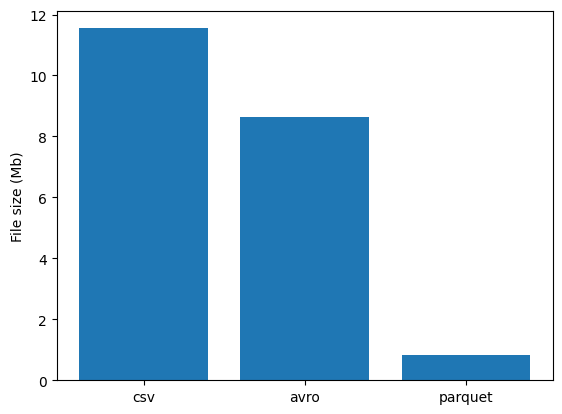

In [71]:
fig, ax = plt.subplots()

format = ['csv', 'avro', 'parquet']
sizes = [csv_size/1024**2, avro_size/1024**2, parquet_size/1024**2]
ax.set_ylabel('File size (Mb)')

ax.bar(format, sizes);

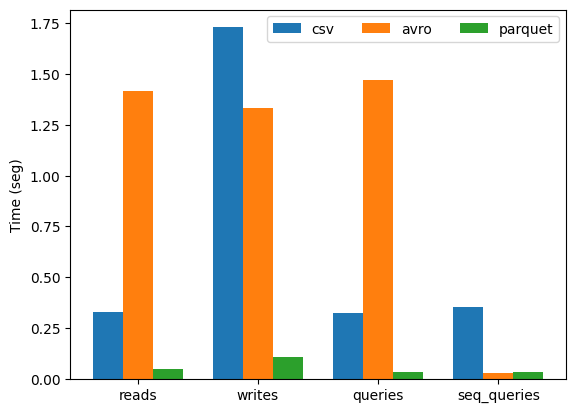

In [252]:
fig, ax = plt.subplots()


ops = ['reads', 'writes', 'queries', 'seq_queries']
format_times = {
    'csv': [csv_read_time, csv_write_time, csv_query_time, csv_query_seq_time],
    'avro': [avro_read_time, avro_write_time, avro_query_time, avro_query_seq_time],
    'parquet': [parquet_read_time, parquet_write_time, parquet_query_time, parquet_query_seq_time],
}

x = list(range(len(ops)))
width = 0.25
multiplier = 0

for attribute, measurement in format_times.items():
    offset = width * multiplier
    rects = ax.bar([x_i + offset for x_i in x], measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('Time (seg)')
ax.set_xticks([x_i + width for x_i in x], ops)
ax.legend(ncols=3);